**Table of contents**<a id='toc0_'></a>    
- [BCG removal](#toc1_)    
- [Distortion correction](#toc2_)    
- [Color measurement](#toc3_)    
  - [Color picker](#toc3_1_)    
  - [Threshold](#toc3_2_)    
  - [Find disk](#toc3_3_)    
  - [Compute CoG and compare to disk center](#toc3_4_)    
  - [Intensity variation on the image](#toc3_5_)    
  - [Colour variation on the image](#toc3_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import numpy as np
%matplotlib ipympl
from src import src
import matplotlib.pyplot as plt
import cv2
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk 
import cv2
import numpy as np
import pandas as pd
import discorpy.util.utility as utils
import discorpy.losa.loadersaver as losa
import discorpy.prep.preprocessing as prep
import discorpy.proc.processing as proc
import discorpy.post.postprocessing as post
import scipy
import math as m
from matplotlib.ticker import FormatStrFormatter

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

def random_draw(n, min_value=0, max_value=100):
    return np.random.randint(min_value, max_value + 1, n)


print(random_draw(2*12,1,12))

[ 5  1 10  6  9 10  4 12  7  9  8 12  4 12  2  6  1  5  3  1  8  1 10  6]


# <a id='toc1_'></a>[BCG removal](#toc0_)

[-5, -6.5]
[-5, -6.5]


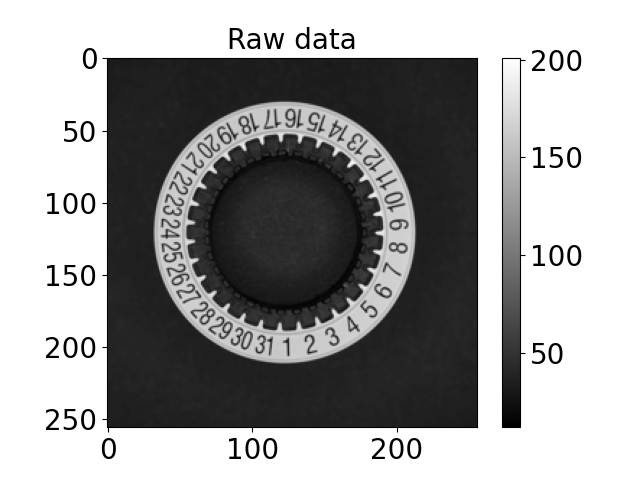

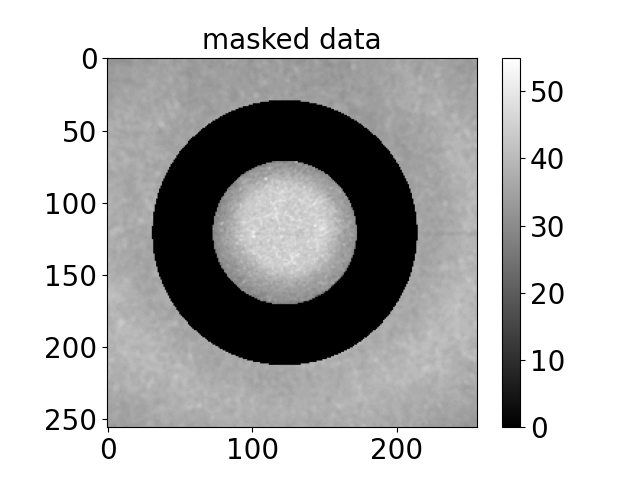

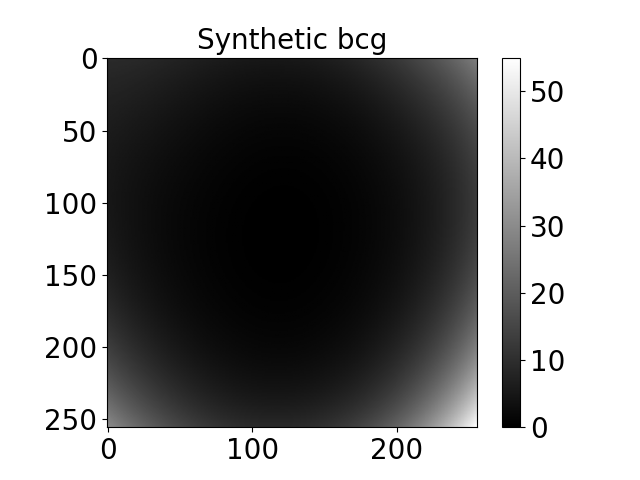

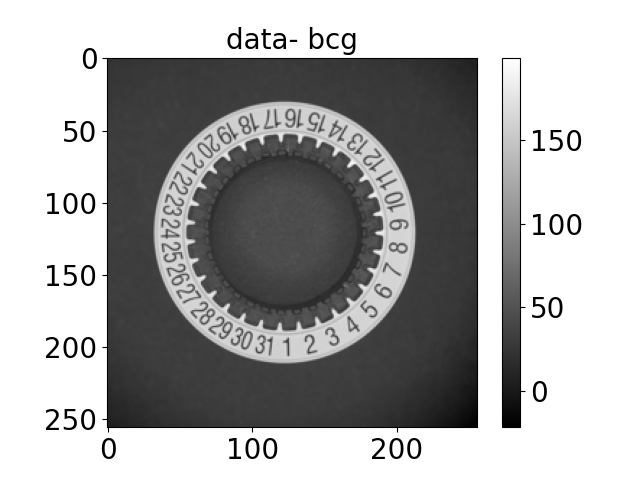

In [ ]:
image = Image.open("data/30mm_BonW_5.bmp").resize((256, 256)) # Simplement pour accélèrer le processing durant le développement

data = np.asarray(image)[:,:,1] # BW => R=G=B
height, width = data.shape

mask = src.build_mask(height, width, 92, [-5,-6.5])    # Construit un masque(disque) de pour ne pas utiliser certaines données
mask += ~src.build_mask(height, width, 50, [-5,-6.5]) # Construit un !masque(disque) de pour ne !pas utiliser certaines données

x = np.linspace(-1,1,width)
y = np.linspace(-1,1,height)
grid_x, grid_y = np.meshgrid(x, y)
synt_bcg, trash = src.polynomial_mask(data, mask, [grid_x, grid_y], order=5)

synt_bcg = (synt_bcg - np.min(synt_bcg))/(np.max(synt_bcg)- np.min(synt_bcg))*np.max(data*mask) # normalize to the image illumination


synt_bcg = synt_bcg
data_bcg = data - synt_bcg # Ideal, the bcg values are cole to 0 comaratively to the disk

plt.close(1)
plt.figure(1)
plt.imshow(data,cmap='gray')
plt.colorbar()
plt.title("Raw data")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

plt.close(2)
plt.figure(2)
plt.imshow(data*mask,cmap='gray')
plt.colorbar()
plt.title("masked data")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

plt.close(3)
plt.figure(3)
plt.imshow(synt_bcg,cmap='gray')
plt.title("Synthetic bcg")
plt.colorbar()
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

plt.close(4)
plt.figure(4)
plt.imshow(data_bcg,cmap='gray')
plt.colorbar()
plt.title("data- bcg")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()



# <a id='toc2_'></a>[Distortion correction](#toc0_)

In [ ]:
imagepath = r"measurments/"


In [ ]:
# Initial parameters
file_path = "measurments/dot.jpg"
output_base = "outputs"
num_coef = 5  # Number of polynomial coefficients
mat0 = losa.load_image(file_path) # Load image
(height, width) = mat0.shape

mat1 = prep.binarization(mat0)
# Calculate the median dot size and distance between them.
(dot_size, dot_dist) = prep.calc_size_distance(mat1)
# Remove non-dot objects
mat1 = prep.select_dots_based_size(mat1, dot_size)
# Remove non-elliptical objects
mat1 = prep.select_dots_based_ratio(mat1)
losa.save_image(output_base + "/segmented_dots.jpg", mat1) # Save image for checking
# Calculate the slopes of horizontal lines and vertical lines.
hor_slope = prep.calc_hor_slope(mat1)
ver_slope = prep.calc_ver_slope(mat1)
print("Horizontal slope: {0}. Vertical slope {1}".format(hor_slope, ver_slope))

# Group points to horizontal lines
list_hor_lines = prep.group_dots_hor_lines(mat1, hor_slope, dot_dist)
list_ver_lines = prep.group_dots_ver_lines(mat1, ver_slope, dot_dist)
list_hor_lines = prep.remove_residual_dots_hor(list_hor_lines, hor_slope)
list_ver_lines = prep.remove_residual_dots_ver(list_ver_lines, ver_slope)
# Save output for checking
losa.save_plot_image(output_base + "/horizontal_lines.png", list_hor_lines, height, width)
losa.save_plot_image(output_base + "/vertical_lines.png", list_ver_lines, height, width)


list_hor_data = post.calc_residual_hor(list_hor_lines, 0.0, 0.0)
list_ver_data = post.calc_residual_ver(list_ver_lines, 0.0, 0.0)
losa.save_residual_plot(output_base + "/hor_residual_before_correction.png",
                      list_hor_data, height, width)
losa.save_residual_plot(output_base + "/ver_residual_before_correction.png",
                      list_ver_data, height, width)

# Calculate the center of distortion
(xcenter, ycenter) = proc.find_cod_coarse(list_hor_lines, list_ver_lines)
# Calculate coefficients of the correction model
list_fact = proc.calc_coef_backward(list_hor_lines, list_ver_lines,
                                    xcenter, ycenter, num_coef)
# Save the results for later use.
losa.save_metadata_txt(output_base + "/coefficients_radial_distortion.txt",
                     xcenter, ycenter, list_fact)
print("X-center: {0}. Y-center: {1}".format(xcenter, ycenter))
print("Coefficients: {0}".format(list_fact))

# Calculate coefficients of the correction model
list_fact = proc.calc_coef_forward(list_hor_lines, list_ver_lines,
                                    xcenter, ycenter, num_coef)

# Load coefficients from previous calculation if need to
# (xcenter, ycenter, list_fact) = losa.load_metadata_txt(
#     output_base + "/coefficients_radial_distortion.txt")



# Correct the image
mat1 = losa.load_image('measurments/dot1.jpg') # Load image
corrected_mat = post.unwarp_image_backward(mat1.astype(np.uint8), xcenter, ycenter, list_fact)
losa.save_image(output_base + "/corrected_image.png", corrected_mat)
losa.save_image(output_base + "/difference.png", corrected_mat - mat1)

# <a id='toc3_'></a>[Color measurement](#toc0_)

1. Color picker
2. Threshold
3. Find disc
4. Compute CoG and compare to disk center

## <a id='toc3_1_'></a>[Color picker](#toc0_)

In [ ]:
def pick_color_from_image():
    zoom = 1.0
    selected_rgb = [None]  

    def load_image():
        path = filedialog.askopenfilename(filetypes=[("Images", "*.png *.jpg *.bmp")])
        if path:
            nonlocal img, zoom
            img = Image.open(path).convert("RGB")
            fit_to_window()

    def fit_to_window():
        nonlocal zoom, tk_img
        if img:
            w, h = img.width, img.height
            cw, ch = canvas.winfo_width(), canvas.winfo_height()
            zoom = min(cw/w, ch/h)
            update_image()

    def update_image():
        nonlocal tk_img
        resized = img.resize((int(img.width*zoom), int(img.height*zoom)), Image.LANCZOS)
        tk_img = ImageTk.PhotoImage(resized)
        canvas.delete("IMG")
        canvas.create_image(0, 0, anchor=tk.NW, image=tk_img, tags="IMG")

    def get_color(event):
        x, y = int(event.x / zoom), int(event.y / zoom)
        if 0 <= x < img.width and 0 <= y < img.height:
            selected_rgb[0] = img.getpixel((x, y))
            rgb = selected_rgb[0]
            color_label.config(text=f"RGB: {rgb} | HEX: #{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}")

    def on_resize(event):
        fit_to_window()

    def on_close():
        root.destroy()

    root = tk.Tk()
    root.title("Color picker")
    root.protocol("WM_DELETE_WINDOW", on_close)

    canvas = tk.Canvas(root, bg="gray")
    canvas.pack(fill=tk.BOTH, expand=True)
    canvas.bind("<Button-1>", get_color)
    canvas.bind("<Configure>", on_resize)

    btn = tk.Button(root, text="Load Image", command=load_image)
    btn.pack(pady=5)

    color_label = tk.Label(root, text="Click on the image", bg="white")
    color_label.pack(pady=5)

    img = None
    tk_img = None

    root.mainloop()
    return selected_rgb[0]  # Return selected RGB after GUI is closed

color = pick_color_from_image()
print("Color:", color)

Color: (166, 166, 166)


## <a id='toc3_2_'></a>[Threshold](#toc0_)

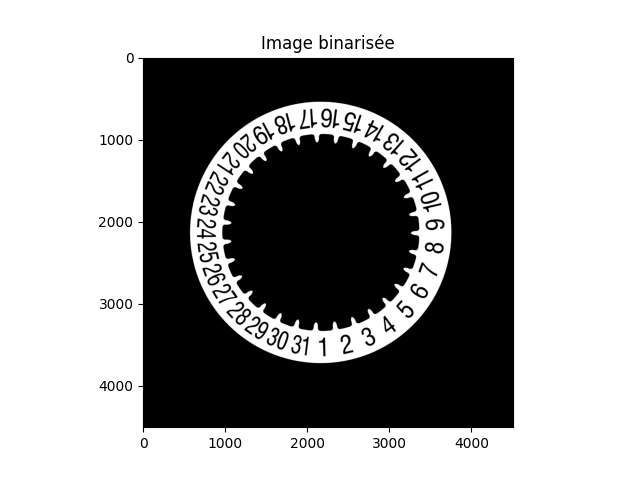

In [ ]:


image = cv2.imread("data/30mm_BonW_5.bmp")[:,:,0]

# lowerThresh = color[0]-10
# higherThresh = color[0]-10
ret,thresh = cv2.threshold(image,100,255,cv2.THRESH_BINARY)

plt.close(0)
plt.figure(0)
plt.imshow(thresh,cmap='gray')
plt.title("Image binarisée")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()


## <a id='toc3_3_'></a>[Find disk](#toc0_)

circles !:  1591


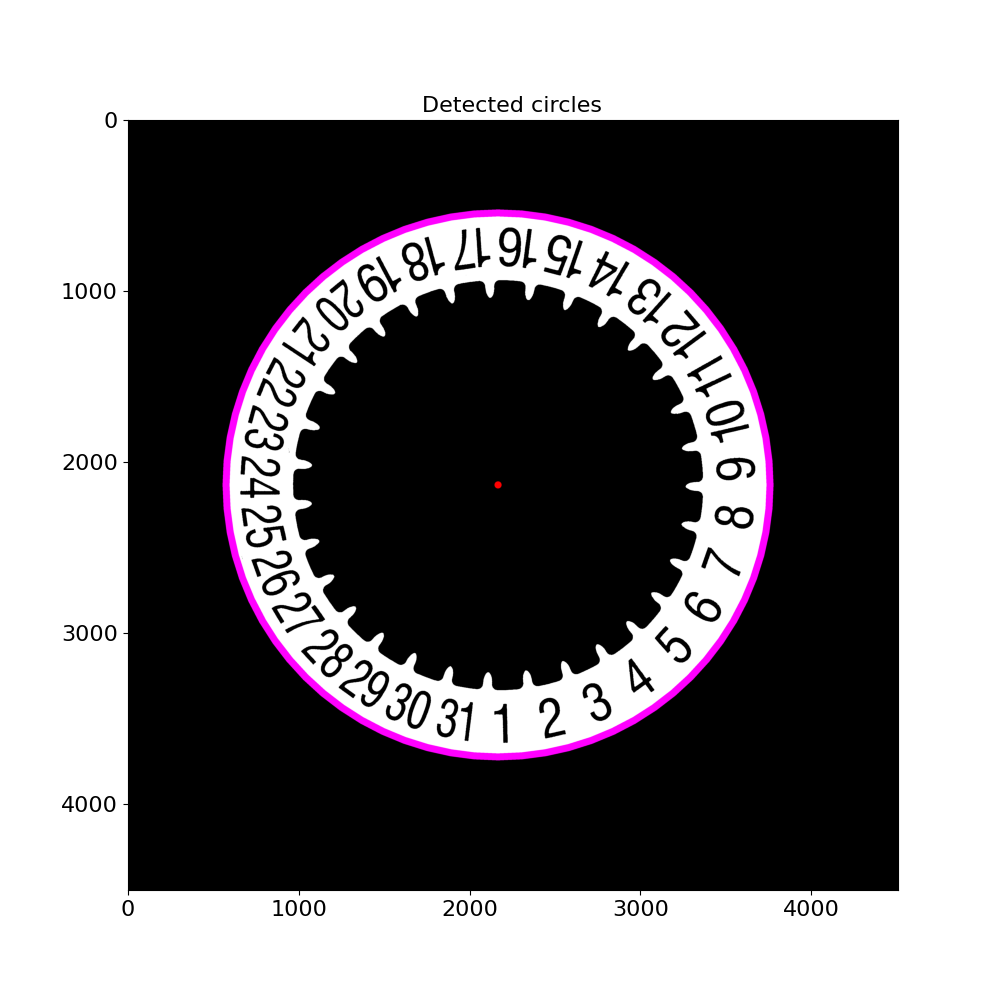

array([[[2164, 2134, 1591]]], dtype=uint16)

In [ ]:
gray = thresh
#
blurred = cv2.GaussianBlur(gray, (9, 9), 2) # improves detection


circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=1570, maxRadius=1610)


output_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
if circles is not None:
    circles = np.uint16(np.around(circles))
    print("circles !: ",circles[0,0,2])
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(output_rgb, center, 1, (255, 0, 0), 40)
        # circle outline
        radius = i[2]
        cv2.circle(output_rgb, center, radius, (255, 0, 255), 40)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(output_rgb)
plt.title("Detected circles")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

circles


## <a id='toc3_4_'></a>[Compute CoG and compare to disk center](#toc0_)

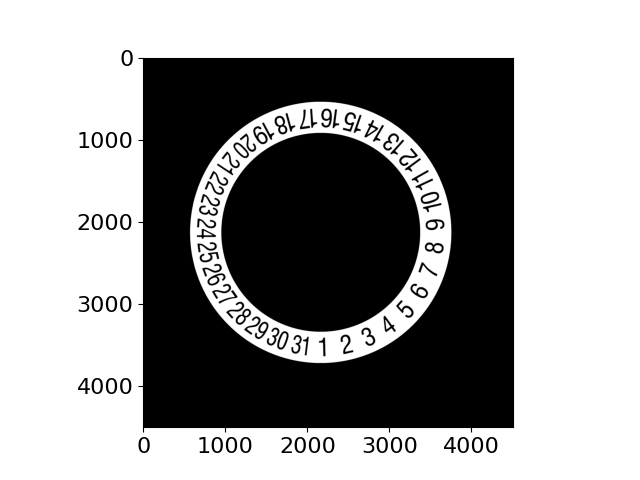

In [ ]:
raddi =[circles[0,0,2], 1210]    # [outer, inner]

image = thresh
[widht, height] = image.shape

center = [circles[0,0,0]-widht/2,circles[0,0,1]-height/2]      # [Delta x, Delta y]

x = np.linspace(-widht/2-center[0],widht/2-center[0],num=widht).astype(np.int64)
y = np.linspace(-height/2-center[1],height/2-center[1],num=height).astype(np.int64)

[X, Y] = np.meshgrid(x,y)
R = np.sqrt(X**2 + Y**2)

mask = R < raddi[0] 
mask &= R > raddi[1]

XI = X*image
YI = Y*image

# Xr = np.zeros_like(image)
xCoG = XI[mask].sum()/image[mask].sum()
yCoG = YI[mask].sum()/image[mask].sum()


plt.close(0)
plt.figure(0)
plt.imshow(mask*image,cmap='gray')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

## <a id='toc3_5_'></a>[Intensity variation on the image](#toc0_)

<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amd\AppData\Local\Temp\ipykernel_2496\775027998.py:71: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_array[center-halfwindowsize:center+halfwindowsize],y_fit,label  = 'fit: $y=\\frac{A}{\sigma\sqrt{2\pi}}e^{-\\frac{(x-\\xi)^2}{2\sigma^2}}$\n $A =$ %.2e $\pm$ %.2e\n $\sigma =$ %.2e $\pm$ %.2e \n$\\xi =$ %.2e $\pm$ %.2e' % (A, DA,C, DC, sigma, Dsigma))


Variation d'intensité sur le disque 164.24739053854015 +/-  3.7812223746557834
0.04604301307019586


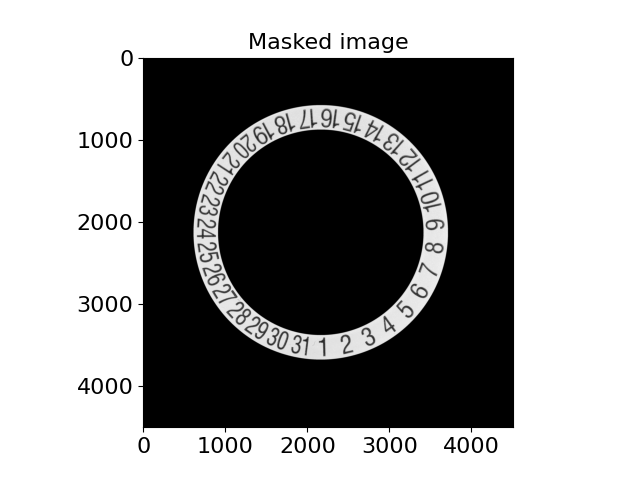

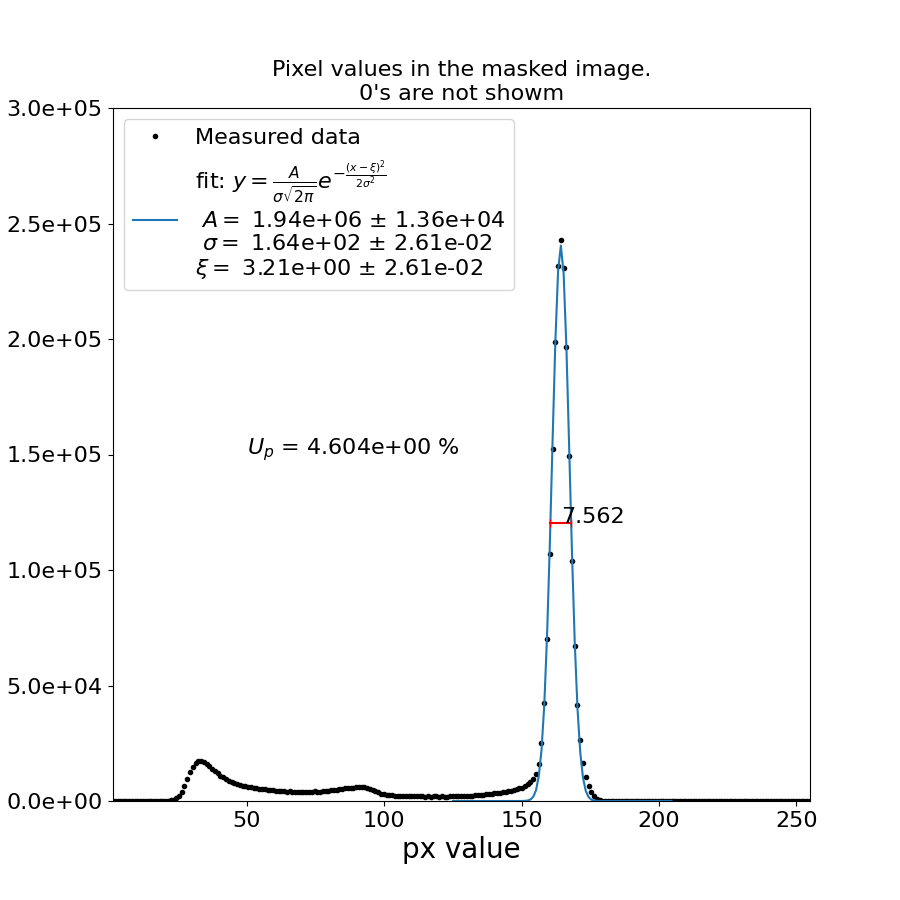

In [ ]:
def _gaussian(x_array, amp, center, sigma):
    return amp*(1/(sigma*(np.sqrt(2*np.pi))))*(np.exp((-0.5)*(((x_array-center)/sigma)**2)))

amp = 2.5e5
center = 164
sigma = 1

halfwindowsize = 40
window = np.linspace(center-halfwindowsize,center+halfwindowsize, halfwindowsize*2-1) # 30mm => 40 pixels

image = Image.open("data/30mm_BonW_5.bmp") # Simplement pour accélèrer le processing durant le développement

data = np.asarray(image)[:,:,1] # BW => R=G=B
mask = R < raddi[0] -42
mask &= R > raddi[1] + 40

data = data*mask
data[widht//2,height//2] = 255

values = pd.DataFrame(data)

counts, bins = np.histogram(values, bins = 256)
y_array = counts
x_array = np.linspace(0, np.size(bins),np.size(bins)-1) 

popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_gaussian, x_array[center-halfwindowsize:center+halfwindowsize], y_array[center-halfwindowsize:center+halfwindowsize], p0=[amp, center, sigma])
perr_gauss = np.sqrt(np.diag(pcov_gauss))

A = popt_gauss[0]
DA = perr_gauss[0]
C = popt_gauss[1]
DC = perr_gauss[1]
sigma = popt_gauss[2]
Dsigma = perr_gauss[2]

y_fit = _gaussian(x_array[center-halfwindowsize:center+halfwindowsize],A,C,sigma)

y = y_fit.max()/2
discriminant = 4*(C**2) - 4*(C**2 + (sigma**2)*m.log(y*sigma*m.sqrt(2*m.pi)/A)/.5)
x_fwhm1 = 0.5*(2*C + m.sqrt(discriminant))
x_fwhm2 = 0.5*(2*C - m.sqrt(discriminant))
x_fwhm = np.array([x_fwhm1, x_fwhm2])
y_fwmh = _gaussian(x_fwhm,A,C,sigma)
FWHM = x_fwhm[0]-x_fwhm[1]


x_center1 = 0.5*(2*C + m.sqrt(discriminant))
x_center2 = 0.5*(2*C - m.sqrt(discriminant))
x_center = 0.5*(x_center1+x_center2)
print("Variation d'intensité sur le disque",x_center, "+/- ",FWHM/2)

U_p = FWHM/x_center
print(U_p)

plt.close(0)
plt.figure(0)
plt.imshow(data*mask,cmap='gray')
plt.title('Masked image')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

plt.close(1)
plt.figure(1,figsize = (9, 9))
plt.plot(x_array,counts,".k",label ="Measured data")
plt.plot(x_array[center-halfwindowsize:center+halfwindowsize],y_fit,label  = 'fit: $y=\\frac{A}{\sigma\sqrt{2\pi}}e^{-\\frac{(x-\\xi)^2}{2\sigma^2}}$\n $A =$ %.2e $\pm$ %.2e\n $\sigma =$ %.2e $\pm$ %.2e \n$\\xi =$ %.2e $\pm$ %.2e' % (A, DA,C, DC, sigma, Dsigma))
plt.plot([x_fwhm1, x_fwhm2],y_fwmh,'r-|')
temptext = "%.3f"%FWHM
plt.text(x_center-0.0065,y_fwmh[0]-15,temptext)
temptext = "$U_p$ = %.3e %%"%(U_p*100)
plt.text(50,1.5e5,temptext)
plt.xlabel("px value")
plt.ylabel("Counts")
plt.title("Simulated pixel intensity distribution")
plt.legend()
plt.title("Pixel values in the masked image.\n0's are not showm")
plt.xlim((1,255))
plt.ylim((0,3e5))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
# plt.yticks()
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

## <a id='toc3_6_'></a>[Colour variation on the image](#toc0_)

<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amd\AppData\Local\Temp\ipykernel_2496\4043054309.py:71: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_array[center-halfwindowsize:center+halfwindowsize],y_fit,label  = 'fit: $y=\\frac{A}{\sigma\sqrt{2\pi}}e^{-\\frac{(x-\\xi)^2}{2\sigma^2}}$\n $A =$ %.2e $\pm$ %.2e\n $\sigma =$ %.2e $\pm$ %.2e \n$\\xi =$ %.2e $\pm$ %.2e' % (A, DA,C, DC, sigma, Dsigma))


Variation d'intensité sur le disque 33.96066827455641 +/-  5.741144637435326
0.338105516123582


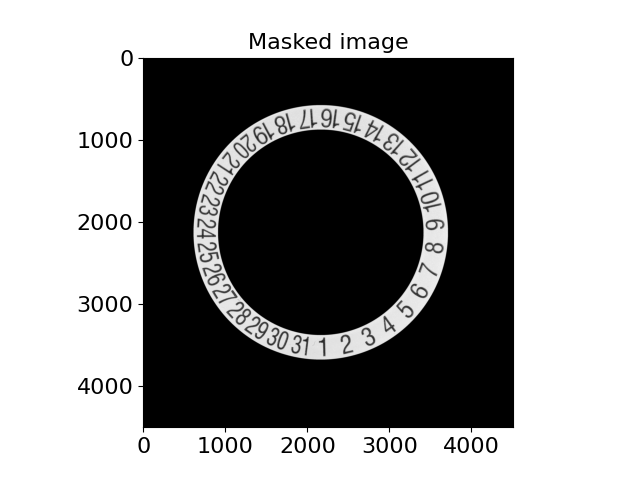

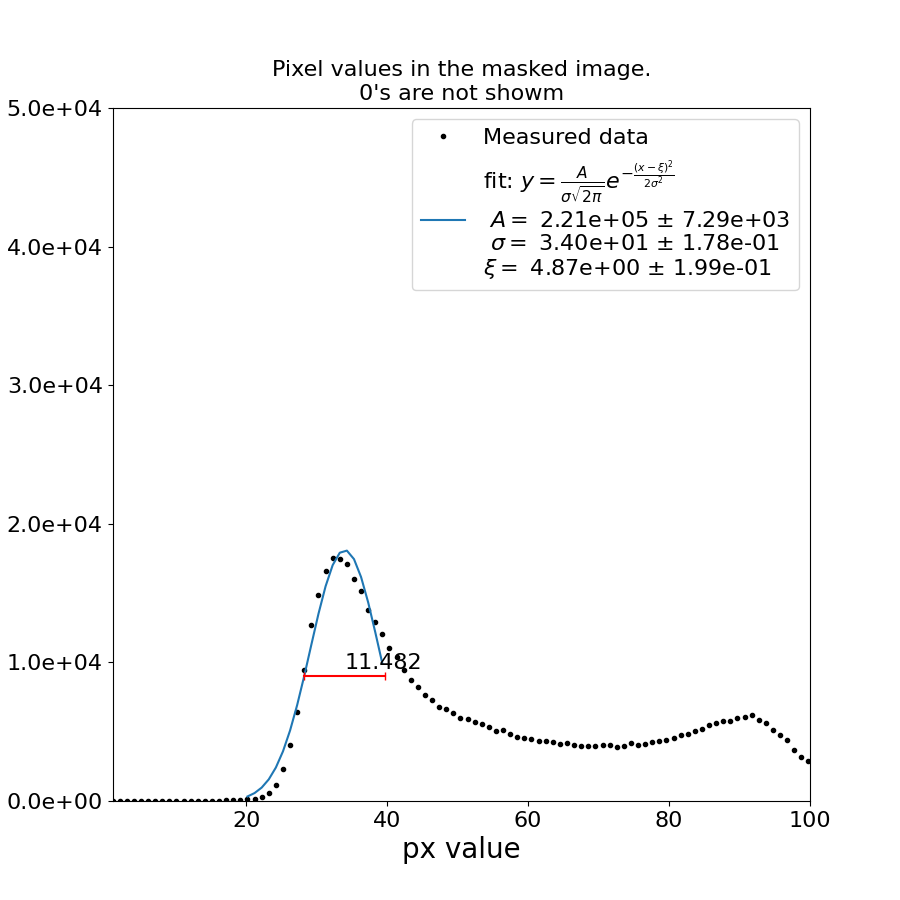

In [ ]:
def _gaussian(x_array, amp, center, sigma):
    return amp*(1/(sigma*(np.sqrt(2*np.pi))))*(np.exp((-0.5)*(((x_array-center)/sigma)**2)))

amp = 2e4
center = 30
sigma = 1

halfwindowsize = 10
window = np.linspace(center-halfwindowsize,center+halfwindowsize, halfwindowsize*2-1) # 30mm => 40 pixels

image = Image.open("data/30mm_BonW_5.bmp") # Simplement pour accélèrer le processing durant le développement

data = np.asarray(image)[:,:,1] # BW => R=G=B
mask = R < raddi[0] -42
mask &= R > raddi[1] + 40

data = data*mask
data[widht//2,height//2] = 255

values = pd.DataFrame(data)

counts, bins = np.histogram(values, bins = 256)
y_array = counts
x_array = np.linspace(0, np.size(bins),np.size(bins)-1) 

popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_gaussian, x_array[center-halfwindowsize:center+halfwindowsize], y_array[center-halfwindowsize:center+halfwindowsize], p0=[amp, center, sigma])
perr_gauss = np.sqrt(np.diag(pcov_gauss))

A = popt_gauss[0]
DA = perr_gauss[0]
C = popt_gauss[1]
DC = perr_gauss[1]
sigma = popt_gauss[2]
Dsigma = perr_gauss[2]

y_fit = _gaussian(x_array[center-halfwindowsize:center+halfwindowsize],A,C,sigma)

y = y_fit.max()/2
discriminant = 4*(C**2) - 4*(C**2 + (sigma**2)*m.log(y*sigma*m.sqrt(2*m.pi)/A)/.5)
x_fwhm1 = 0.5*(2*C + m.sqrt(discriminant))
x_fwhm2 = 0.5*(2*C - m.sqrt(discriminant))
x_fwhm = np.array([x_fwhm1, x_fwhm2])
y_fwmh = _gaussian(x_fwhm,A,C,sigma)
FWHM = x_fwhm[0]-x_fwhm[1]


x_center1 = 0.5*(2*C + m.sqrt(discriminant))
x_center2 = 0.5*(2*C - m.sqrt(discriminant))
x_center = 0.5*(x_center1+x_center2)
print("Variation d'intensité sur le disque",x_center, "+/- ",FWHM/2)

U_p = FWHM/x_center
print(U_p)

plt.close(0)
plt.figure(0)
plt.imshow(data*mask,cmap='gray')
plt.title('Masked image')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

plt.close(1)
plt.figure(1,figsize = (9, 9))
plt.plot(x_array,counts,".k",label ="Measured data")
plt.plot(x_array[center-halfwindowsize:center+halfwindowsize],y_fit,label  = 'fit: $y=\\frac{A}{\sigma\sqrt{2\pi}}e^{-\\frac{(x-\\xi)^2}{2\sigma^2}}$\n $A =$ %.2e $\pm$ %.2e\n $\sigma =$ %.2e $\pm$ %.2e \n$\\xi =$ %.2e $\pm$ %.2e' % (A, DA,C, DC, sigma, Dsigma))
plt.plot([x_fwhm1, x_fwhm2],y_fwmh,'r-|')
temptext = "%.3f"%FWHM
plt.text(x_center-0.0065,y_fwmh[0]+500,temptext)
temptext = "$U_p$ = %.3e %%"%(U_p*100)
plt.text(50,1.5e5,temptext)
plt.xlabel("px value")
plt.ylabel("Counts")
plt.title("Simulated pixel intensity distribution")
plt.legend()
plt.title("Pixel values in the masked image.\n0's are not showm")
plt.xlim((1,100))
plt.ylim((0,5e4))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
# plt.yticks()
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()